# sotodlib G3tSMuRF Tutorial
## Feb 1st 2022

## Outline

1) Software setup and data storage locations

2) An introduction to the current status of G3tSmurf -- our mechanism for loading SO SMuRF data into sotodlib
    
    Note for future users: The databasing and backend of G3tSmurf is subject to change because it needs to be brought in-line with the larger sotodlib system. However, the AxisManagers output by G3tSmurf.load_data are the data format for sotodlib timestream analysis.  

3) An overview of the current features of AxisManagers, FlagManager/flags, and Timestream Operations 

# Tutorial Loading and Module Setup

### On `simons1` 

Before you can work with any of this software you need to make sure you have all the different packages installed. If you are planning to help develop any of the software you will eventually need to clone and install the packages you plan to work with. 

However, we have pre-installed versions you can work with using modules. [Follow these instructions on the Pre-installed shared stacks](http://simonsobservatory.wikidot.com/pwg:duf:tod-software-stack) to setup your environment to load the pre-installed modules.

This tutorial is written to use:

```
user@simons1: $ module load tod_stack_unstable
user@simons1: $ module list
Currently Loaded Modulefiles:
 1) anaconda3/200627      9) spt3g_software/210824
 2) mpi4py_mpich/200627  10) pixell/210824
 3) libaatm/1.0.8        11) so_pysm_models/201029
 4) libmadam/1.0.2       12) tod_stack/220103
 5) suitesparse/5.4.0    13) sotodlib/000000_unstable
 6) toast_deps/201209    14) so3g/000000_unstable
 7) toast_2.3/210824     15) tod_stack_unstable
 8) qpoint/1.11.1
```

The `module load tod_stack_unstable` command will load all the software used in this tutorial (and then some). The "unstable" version uses the most recent build of the main github branches and will stay up to date, but they may also be a bit more unstable than other versions.

If you do a local install of one of these packages and want to use that instead, you can use `module unload package` to remove those modules from the loaded options. 

Many people choose to put these `module load <package>` commands in their `.bashrc` files so they do not have to remember to run them. 

When using modules in conjunction with `jupyter notebook` you need to load the modules before starting the notebook. Once started, you will not be able to reload modules if they are updated, you will have to restart your server to successfully load an updated module. You can know you have done everything correctly if you can run all the import statements needed for this tutorial:

## Software Packages 

#### [`spt3g-software`](https://github.com/CMB-S4/spt3g_software)
Defines the SO saved file format and software for interfacing with the files. (Also, a lot of other things SO isn't using at the moment). 

#### [`so3g`](https://github.com/simonsobs/so3g)
SO specific extensions to SPT3G-software. Contains a combination of DAQ and TOD2Maps software. Anything built in C++ is in this repository.

Documentation is on readthedocs here: https://so3g.readthedocs.io/en/latest/

#### [`sotodlib`](https://github.com/simonsobs/sotodlib)
Data processing for the SO time ordered data software stack. Includes simulation setups, data loading, and processing. At this point this is a completely python based library.

Documentation is on readthedocs here: https://sotodlib.readthedocs.io/en/latest/

In [14]:
%matplotlib notebook

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import sqlalchemy as db

from so3g.proj import Ranges, RangesMatrix

import sotodlib.core as core
from sotodlib.io.load_smurf import (G3tSmurf, Observations, TuneSets, \
                                    Channels, Files, ChanAssignments)
from sotodlib.io.load_smurf import load_file

import sotodlib.tod_ops.filters as filters
from sotodlib.tod_ops import fourier_filter, rfft, detrend_tod

from sotodlib.core import FlagManager
import sotodlib.flags as flags

## File System


#### On `simons1`, each lab has a base directory of `/mnt/so1/data/<lab-location>/`

Within that base directory we have all configured our Smurf systems / OCS such that the file system is:

* `timestreams/`
    * `<5 digit ctime>/`
        * `<stream-id>/` (stream id generally takes the form of crateXslotY)
            * `<10 digit ctime>_XYZ.g3` -- All the written out g3 files
* `smurf/`
    * `<5 digit ctime>/`
        * `<stream-id>/` (stream id generally takes the form of crateXslotY)
            * `<10 digit ctime>_smurf_action/` 
                * `outputs/` -- outputs from `pysmurf`/`sodetlib` during action
                * `plots/` -- plots made by `pysmurf`/`sodetlib` during action
* `hk/`
    * `<5 digit ctime>/`
        * `<10 digit ctime>.g3` -- output housekeeping data
        
    


## `G3tSmurf` Databasing

The `G3tSmurf` system uses the SO file system and save patterns to build a set of databases needed to locate data. Updating the databases requires running a few pre-defined commands on an existing database (or to build a new one). From scratch, these databases currently take between minutes to ~hour to build and will scale as we get more data. **Katie recommends that each lab have their own person responsible for building a shared database and that that person sets up a cronjob to update these automatically. [There are docs and a specific script for this](https://sotodlib.readthedocs.io/en/latest/g3tsmurf.html#database-creation-and-upkeep).**

The Databasing and their queries are currently built using `SQLAlchemy`. This is a nice python way of connecting to an sqlite database, both for building databases and running queries. There are examples of queries in the cells below but for a more comprehensive guide look for SQLAlchemy Tutorials such as: https://docs.sqlalchemy.org/en/14/orm/tutorial.html#querying

### Databases

A more up-to-date description of the databases my be [in the docs]( https://sotodlib.readthedocs.io/en/latest/g3tsmurf.html#module-sotodlib.io.g3tsmurf_db).

#### Observations

These are made every time specific SMuRF actions are found in the `smurf/` archive. We are currently indexing:  
* take_stream_data
* stream_data_on
* take_noise_psd 
* take_g3_data
* stream_g3_on

This can be expanded as desired

#### TuneSets / Tunes

Tunes: indexes every Tune file. 
TuneSets: indexes every Tune file where the channel assignments have changed

#### Channels

All SMuRF channels we've found in the channel assignments. We make a new set every time there's a new channel assignment

* channel names: `<ctime>_<stream_id>_A_BBB` where `A` is SMuRF band and `BBB` is SMuRF Channel. 
    * ctime is the ctime of the associated channel assignment for that channel. 
* Also tracks: channel, subband, frequency

#### Files
Indexes all .g3 files, whether or not they are part of an observation.

## Connect to G3tSmurf

G3Smurf needs to know where all your files are saved and what database you want to use. If the database path you give it does not exist a new database will be created.

The `session` object is how you query the database. 

In [3]:
## LATRt Data
SMURF = G3tSmurf(archive_path= '/mnt/so1/data/chicago-latrt/timestreams/',
                meta_path = '/mnt/so1/data/chicago-latrt/smurf/',
                db_path='/mnt/so1/users/kmharrin/smurf_context/latrt_db_v4.db')

## K2SO Data
#SMURF = G3tSmurf(archive_path= '/mnt/so1/data/ucsd-k2so/timestreams/',
#                meta_path = '/mnt/so1/data/ucsd-k2so/smurf/',
#                db_path='/home/jlashner/indexes/k2so_db_ext.db')

## LATR Data
#SMURF = G3tSmurf(archive_path= '/mnt/so1/data/penn-latr/timestreams',
#                meta_path = '/mnt/so1/data/penn-latr/smurf/',
#                db_path='/mnt/so1/users/iuliano/smurf_context.db')

session = SMURF.Session()

## Querying Databases

In [11]:
## find all the observations in a specific time period

q = session.query(Observations).filter(Observations.start >= dt.datetime(2022,1,1), 
                                       Observations.start <= dt.datetime(2022,1,13))

print(f'I found {q.count()} observations.')
print(f'The first observation in the query is:\n\t {q[0]}')

print('But sometimes these are out of order, so I will sort by Observation time')
q = q.order_by(Observations.start)
print(f'Now the first observation is:\n\t {q[0]}')

I found 1128 observations.
The first observation in the query is:
	 ufm_cv4_1640997271: 2022-01-01 00:34:31.916412 -> 2022-01-01 00:39:32.242251 [0:05:00.325839] (tuneStabilty)
But sometimes these are out of order, so I will sort by Observation time
Now the first observation is:
	 ufm_cv4_1640997271: 2022-01-01 00:34:31.916412 -> 2022-01-01 00:39:32.242251 [0:05:00.325839] (tuneStabilty)


In [6]:
## Find the most recent Tuning File relative to a time

time = dt.datetime(2022,1,4)
stream_id = 'ufm_cv4'

q = session.query(TuneSets).filter(TuneSets.start <= time, 
                                  TuneSets.stream_id == stream_id)
tune = q.order_by( db.desc(TuneSets.start) ).first()

print(f'The last tune file before {time} for stream_id {stream_id} is {tune.name}')
print(f'This tune file was created on {tune.start}')
print(f'and it can be found at: \n {tune.path}')

The last tune file before 2022-01-04 00:00:00 for stream_id ufm_cv4 is 1639781402_tune.npy
This tune file was created on 2021-12-17 22:50:02
and it can be found at: 
 /mnt/so1/data/chicago-latrt/smurf/16397/ufm_cv4/1639781226_setup_notches/outputs/1639781402_tune.npy


In [9]:
## Find all the SMuRF channels within a specific resonator frequency range

f_start = 5860
f_stop = 5870
stream_id = 'crate1slot2'

q = session.query(Channels).join(TuneSets, Channels.ca_id!= None).filter(Channels.frequency > f_start, 
                                                 Channels.frequency<= f_stop,
                                                 TuneSets.start >= dt.datetime(2021,3,1),
                                                 TuneSets.stream_id == stream_id)

print(f'I found {q.count()} between {f_start} and {f_stop} MHz')
channels = q.all()
ctimes = np.unique( [ch.chan_assignment.ctime for ch in channels])
print(f'These Channels are from {len(ctimes)} different master assignments')

print('Example Names:')
for i in range(10):
    print( '\t', channels[i].name)

I found 202464 between 5860 and 5870 MHz
These Channels are from 135 different master assignments
Example Names:
	 sch_1612981362_3_372
	 sch_1612981362_3_012
	 sch_1612981362_3_076
	 sch_1612981362_3_140
	 sch_1612981362_3_268
	 sch_1612982242_3_372
	 sch_1612982242_3_012
	 sch_1612982242_3_076
	 sch_1612982242_3_140
	 sch_1612982242_3_268


## Loading data -- From Files

Loading data from a single .g3 files into an AxisManager should be quite straightforward:

In [16]:
fname = '/mnt/so1/data/chicago-latrt/timestreams/16409/ufm_cv4/1640997271_000.g3'

aman = load_file(fname)


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


In [1]:
plt.figure()
plt.plot( aman.timestamps, aman.signal[433] )

NameError: name 'plt' is not defined

# Loading Observations 

Technically our loading options work between two times (defined as either ctime of Datetime objects). But it's pretty easy to use that to load observations.

In [28]:
## Choose a specific interesting observation (Assuming you're looking at the LATRt database)

## this observation is an example where we were doing nothing but taking noise
obs = session.query(Observations).filter(Observations.obs_id == 'ufm_cv4_1637791238' ).one()

## this observation has a lot of square waves because we were taking efficiency measurements
#obs = session.query(Observations).filter(Observations.obs_id == 'ufm_cv4_1639411931' ).one()

aman = SMURF.load_data(obs.start, obs.stop)


## Right now this data is returned in phase. 
# Let's change it to pA (yes, we need to add unit control)
phase_to_pA = 9e6/(2*np.pi)
aman.signal *= phase_to_pA

100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


# AxisManagers -- The new shiny TOD Object

AxisManagers have a lot of documentation. It is worth going through if you're confused: https://sotodlib.readthedocs.io/en/latest/axisman.html

* Fields and Organization
* Manipulating AxisManagers


## Fields and Organization

In [30]:
def print_aman_info(aman):
    if 'timestamps' in aman:
        print("""This observation is {} minutes long.
                 It has {} channels loaded and {} samples""".format(round((aman.timestamps[-1]-aman.timestamps[0])/60.,2),
                                                                              aman.dets.count, aman.samps.count))

    print('This aman AxisManager has {} Axes: '.format(len(aman._axes)))
    for k in aman._axes:
        print('\t{} with {} entries'.format(aman[k].name, aman[k].count ) )

    print('This aman  AxisManager has fields : [axes]')
    for k in aman._fields:
        print('\t{} : {}'.format(k, aman._assignments[k]) )
        if type(aman._fields[k]) is core.AxisManager:
            for kk in aman[k]._fields:
                print('\t\t {} : {}'.format(kk, aman[k]._assignments[kk] ))
print_aman_info(aman)

This observation is 2.01 minutes long.
                 It has 880 channels loaded and 24063 samples
This aman AxisManager has 3 Axes: 
	dets with 880 entries
	samps with 24063 entries
	bias_lines with 16 entries
This aman  AxisManager has fields : [axes]
	timestamps : ['samps']
	signal : ['dets', 'samps']
	ch_info : ['dets']
		 band : ['dets']
		 channel : ['dets']
		 frequency : ['dets']
		 rchannel : ['dets']
		 ruid : ['dets']
	primary : ['samps']
		 UnixTime : ['samps']
		 FluxRampIncrement : ['samps']
		 FluxRampOffset : ['samps']
		 Counter0 : ['samps']
		 Counter1 : ['samps']
		 Counter2 : ['samps']
		 AveragingResetBits : ['samps']
		 FrameCounter : ['samps']
		 TESRelaySetting : ['samps']
	biases : ['bias_lines', 'samps']
	flags : ['dets', 'samps']


### Channels

The loading function will automatically name the channels in for format discussed above (related to the channel assignment ctime, smurf band, and smurf channel). 


In [32]:
print( aman.dets.vals )

['sbch_0_002' 'sbch_0_004' 'sbch_0_005' 'sbch_0_010' 'sbch_0_012'
 'sbch_0_016' 'sbch_0_018' 'sbch_0_023' 'sbch_0_024' 'sbch_0_029'
 'sbch_0_031' 'sbch_0_032' 'sbch_0_034' 'sbch_0_035' 'sbch_0_040'
 'sbch_0_042' 'sbch_0_044' 'sbch_0_045' 'sbch_0_056' 'sbch_0_059'
 'sbch_0_060' 'sbch_0_064' 'sbch_0_066' 'sbch_0_067' 'sbch_0_068'
 'sbch_0_069' 'sbch_0_071' 'sbch_0_072' 'sbch_0_076' 'sbch_0_083'
 'sbch_0_087' 'sbch_0_088' 'sbch_0_089' 'sbch_0_091' 'sbch_0_093'
 'sbch_0_095' 'sbch_0_096' 'sbch_0_099' 'sbch_0_100' 'sbch_0_106'
 'sbch_0_109' 'sbch_0_111' 'sbch_0_112' 'sbch_0_114' 'sbch_0_116'
 'sbch_0_117' 'sbch_0_124' 'sbch_0_125' 'sbch_0_128' 'sbch_0_130'
 'sbch_0_131' 'sbch_0_132' 'sbch_0_133' 'sbch_0_135' 'sbch_0_138'
 'sbch_0_140' 'sbch_0_147' 'sbch_0_148' 'sbch_0_151' 'sbch_0_153'
 'sbch_0_159' 'sbch_0_160' 'sbch_0_162' 'sbch_0_163' 'sbch_0_164'
 'sbch_0_165' 'sbch_0_170' 'sbch_0_172' 'sbch_0_173' 'sbch_0_176'
 'sbch_0_178' 'sbch_0_181' 'sbch_0_183' 'sbch_0_188' 'sbch_0_189'
 'sbch_0_1

<IPython.core.display.Javascript object>


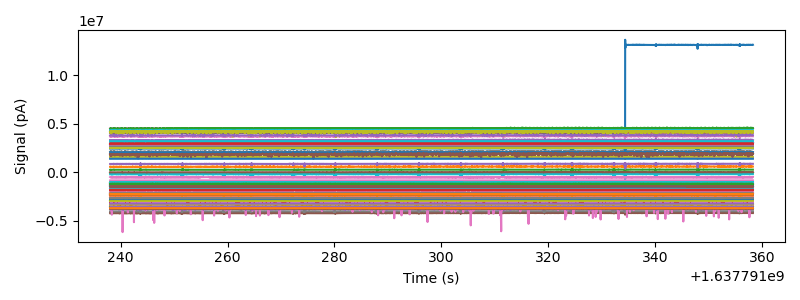

In [34]:
fig = plt.figure(figsize=(8,3))

for i in range(0,aman.dets.count,10):
    plt.plot( aman.timestamps, aman.signal[i] )
plt.ylabel('Signal (pA)')
plt.xlabel('Time (s)')

fig.tight_layout()

## Manipulating AxisManagers

Important AxisManager functions to know about:
* restrict
* wrap
* wrap_new
* move


#### restrict
The nice thing about using `restrict` along the `samps` axis is now *every* item in the AxisManager that has a piece along the `samps` axis is cut in the same way. Ex: It cuts both `aman.timestamps` and `aman.signal` 

In [38]:
## Remove a section from the beginning
aman.restrict('samps', (1000,None))

AxisManager(timestamps[samps], signal[dets,samps], ch_info*[dets], primary*[samps], biases[bias_lines,samps], flags*[dets,samps], dets:LabelAxis(880), samps:OffsetAxis(23808), bias_lines:LabelAxis(16))

#### `wrap()` and `wrap_new()`

Specific Docs: https://sotodlib.readthedocs.io/en/latest/axisman.html#sotodlib.core.AxisManager.wrap

We might want to add new fields to the `aman`, which we can do using the `wrap(name, data, axis_map=None)` function. As an example, let's calculate the mean of the different channels signals (the common mode) and add that to the `aman`.

In [39]:
sig_mean = np.mean( aman.signal, axis = 0)
aman.wrap('sig_mean', sig_mean, [(0,aman.samps)])

AxisManager(timestamps[samps], signal[dets,samps], ch_info*[dets], primary*[samps], biases[bias_lines,samps], flags*[dets,samps], sig_mean[samps], dets:LabelAxis(880), samps:OffsetAxis(23808), bias_lines:LabelAxis(16))

`wrap_new(name, shape, cls=None)` creates a new empty field to add to the AxisManager. (Basically saves some lines of code). As an example, let's say we're calculating a value per channel:

In [40]:
aman.wrap_new('pA_to_pW', shape=('dets',), dtype='float64')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

#### move(name, new_name)

Rename or remove a data field. If `new_name` is `None` the field is deleted.

# Timestream Operations and Flags

In [42]:
import sotodlib.tod_ops.filters as filters
from sotodlib.tod_ops import fourier_filter, rfft, detrend_tod

## Detrend Signal

With detector data, the first thing we're basically always going to want to do it detrend the data. There are several options that can be set to `detrend_tod`, but if you just want to remove a straight line from every channel its:

In [43]:
detrend_tod( aman )

AxisManager(timestamps[samps], signal[dets,samps], ch_info*[dets], primary*[samps], biases[bias_lines,samps], flags*[dets,samps], sig_mean[samps], pA_to_pW[dets], dets:LabelAxis(880), samps:OffsetAxis(23808), bias_lines:LabelAxis(16))

<IPython.core.display.Javascript object>


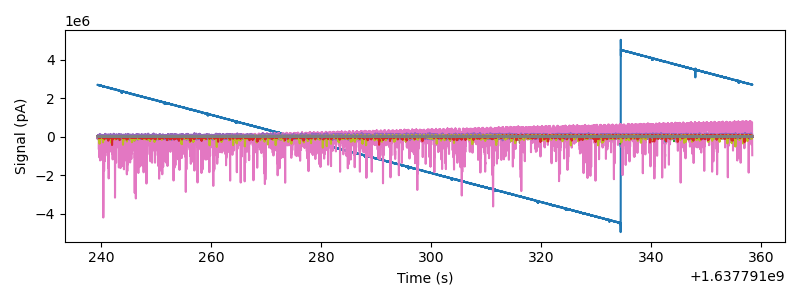

In [44]:
fig = plt.figure(figsize=(8,3))

for i in range(0,aman.dets.count,10):
    plt.plot( aman.timestamps, aman.signal[i] )
plt.ylabel('Signal (pA)')
plt.xlabel('Time (s)')

fig.tight_layout()

## Fourier Transforming and Filtering

### Fourier Transforming

In `sotodlib.tod_ops` we have an `rfft` function that implements a real-valued FFT using `pyfftw` to optimize the execution time. This function has a variety of detrending, resizing, and windowing options to change how the FFT behaves. It will work well for general cases but may not be the best for all options. 

In [45]:
ffts, freqs = rfft(aman, resize=None)

Calculating the white noise levels in the detectors by assuming everything between 11 and 20 Hz is just white noise. Is obviously going to break many many places (but useful for this example. Also yes, we need a `psd` function)

In [46]:
tsamp = np.median(np.diff(aman.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman.samps.count))**2)

fmsk = np.all([freqs > 11, freqs<20], axis=0)
det_white_noise = np.median(np.sqrt(np.abs(ffts[:,fmsk])**2/norm_fact), axis=1)

<IPython.core.display.Javascript object>


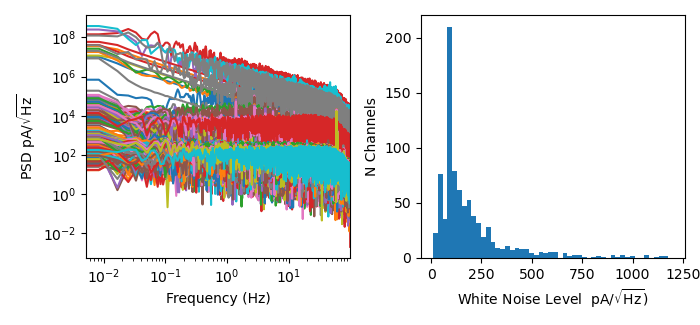

In [48]:
fig = plt.figure(figsize=(7,3.25))
plt.subplot(1,2,1)
for i in range(aman.dets.count):
    plt.loglog( freqs, np.sqrt(np.abs(ffts[i])**2/norm_fact) )
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')
plt.xlim(None, np.max(freqs))
plt.subplot(1,2,2)
plt.hist(det_white_noise,bins=50, range=(10,1200))
plt.ylabel('N Channels');
plt.xlabel('White Noise Level  $\mathrm{pA / \sqrt{Hz}}$)')
fig.tight_layout()

## Filtering

We've created `sotodlib.tod_ops.fourier_filter` which is meant to be an easy way of applying / testing out different fouier level filters. Because it's meant to be "easy" it might not be the best in all cases, but it's definitely a good place to start. `fourier_filter` takes a `filt_function` as the second argument, this can be any function of the form `f(freqs, tod)` that returns a fourier space filter. There are some pre-defined ones in `sotodlib.tod_ops.filters` that are defined with a decorator that makes calling them in one line pretty easy.

Check the docs (https://sotodlib.readthedocs.io/en/latest/tod_ops.html#fourier-space-filters) for a list of default options. Know that we've identified some places where this setup is "slow" and working to speed it up may slightly change the API for interacting with it. 

### LATRt Example

~~If you are still interacting with the data from that specific LATRt observation, it has an 8 Hz chopped signal buried in it. Let's look for it. ~~

Updates to this notebook mean the loaded observation no longer points to the observation with a chopped signal

In [49]:
my_special_filter = filters.high_pass_butter4(fc=4)*filters.low_pass_butter4(fc=12)
aman.wrap('filt_signal', filters.fourier_filter( aman, my_special_filter ) )

## If you want to replace signal you can do: aman.signal = filters.fourier_filter( aman, my_special_filter )

AxisManager(timestamps[samps], signal[dets,samps], ch_info*[dets], primary*[samps], biases[bias_lines,samps], flags*[dets,samps], sig_mean[samps], pA_to_pW[dets], filt_signal[880,23808], dets:LabelAxis(880), samps:OffsetAxis(23808), bias_lines:LabelAxis(16))

In [50]:
## specific to that one LATRt observation
good_channels = [236, 274, 364, 458,]

good_idx = np.where( np.all([aman.ch_info.band == 3,
                             [ch in good_channels for ch in aman.ch_info.channel]], axis=0))[0]
print(good_idx)

[759 775 821 861]


In [ ]:
#aman.restrict( 'channels', aman.channels.vals[good_idx] )

<IPython.core.display.Javascript object>


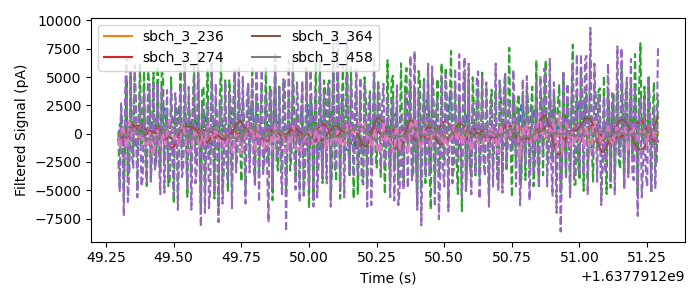

In [52]:
fig = plt.figure(figsize=(7,3))

tmsk = np.all( [aman.timestamps >= aman.timestamps[0]+10,
                aman.timestamps < aman.timestamps[0]+12], axis=0)
for i in good_idx:
    plt.plot( aman.timestamps[tmsk], aman.signal[i][tmsk],  ls='--' )
    plt.plot( aman.timestamps[tmsk], aman.filt_signal[i][tmsk], label=aman.dets.vals[i] )

plt.legend(ncol=2)
plt.ylabel( 'Filtered Signal (pA)' )
plt.xlabel( 'Time (s)' )
fig.tight_layout()

In [53]:
from sotodlib.core import FlagManager
import sotodlib.flags as flags

In [54]:
aman.flags

FlagManager(dets:LabelAxis(880), samps:OffsetAxis(23808))

## FlagManager

Each AxisManager based `aman` will have a `FlagManager` object called `flags` to organize and manage the different flags on the data. `FlagManager` is a special type of `AxisManager` that only accepts entries aligned along the `channels` axis the `samps` axis or both. 
Each flag inside the manager is either a `Ranges` or a `RangesMatrix` from `so3g`. These work pretty similarly to the `moby2.CutsVector` if you are familiar with those. They have a C++ backing but in many ways act like boolean arrays in python. Both `Ranges` and `RangesMatrix` track sample offsets and are savable in the `g3` format, so when we get to a point of needing to save these guys it should be straightforward.

If you input a boolean mask for `channels`, it will get changed to a `RangesMatix` in the backend so that we can keep the math nice/easy. 

The `FlagManager` provides functionality for buffering and combining different cuts/flags depending on what you would like to do with them during the analysis.

#### Quick `Ranges` Aside


In [55]:
from so3g.proj import Ranges, RangesMatrix

In [56]:
t1_flag = Ranges(aman.samps.count, aman.samps.offset)
t1_flag.add_interval( 100,200)
print('T1: {}'.format(t1_flag.ranges()))
print('~T1: {}'.format((~t1_flag).ranges()))

t2_flag = Ranges(aman.samps.count,aman.samps.offset)
t2_flag.add_interval( 150,250)
print('T2: {}'.format(t2_flag.ranges()))

print('T1 + T2 = {}'.format( (t1_flag+t2_flag).ranges()))
print('T1 * T2 = {}'.format( (t1_flag*t2_flag).ranges()))

T1: [[100 200]]
~T1: [[    0   100]
 [  200 23808]]
T2: [[150 250]]
T1 + T2 = [[100 250]]
T1 * T2 = [[150 200]]


## Flags Example

Right now we don't have a great per-sample Flag example, (although glitches will be encountered eventually), but let's build some detector level cuts!

In [57]:
aman.flags.wrap( 'high_noise', det_white_noise > 1200)
aman.flags.wrap( 'low_noise', det_white_noise < 100)

In [58]:
aman.flags

FlagManager(high_noise[dets,samps], low_noise[dets,samps], dets:LabelAxis(880), samps:OffsetAxis(23808))

In [59]:
## Check which detectors have any cuts
aman.flags.has_cuts()
#aman.flags.reduce()[good_idx[0]].mask()

array(['sbch_0_002', 'sbch_0_005', 'sbch_0_016', 'sbch_0_029',
       'sbch_0_035', 'sbch_0_042', 'sbch_0_056', 'sbch_0_064',
       'sbch_0_069', 'sbch_0_091', 'sbch_0_093', 'sbch_0_099',
       'sbch_0_109', 'sbch_0_125', 'sbch_0_133', 'sbch_0_163',
       'sbch_0_173', 'sbch_0_176', 'sbch_0_181', 'sbch_0_195',
       'sbch_0_213', 'sbch_0_221', 'sbch_0_226', 'sbch_0_232',
       'sbch_0_237', 'sbch_0_245', 'sbch_0_264', 'sbch_0_275',
       'sbch_0_277', 'sbch_0_284', 'sbch_0_285', 'sbch_0_309',
       'sbch_0_313', 'sbch_0_328', 'sbch_0_338', 'sbch_0_345',
       'sbch_0_354', 'sbch_0_355', 'sbch_0_377', 'sbch_0_403',
       'sbch_0_405', 'sbch_0_413', 'sbch_0_441', 'sbch_0_443',
       'sbch_0_469', 'sbch_0_473', 'sbch_0_477', 'sbch_0_483',
       'sbch_0_485', 'sbch_0_498', 'sbch_0_501', 'sbch_0_505',
       'sbch_0_507', 'sbch_1_002', 'sbch_1_021', 'sbch_1_040',
       'sbch_1_059', 'sbch_1_066', 'sbch_1_068', 'sbch_1_082',
       'sbch_1_087', 'sbch_1_091', 'sbch_1_092', 'sbch_

In [60]:
## Check which channels are cut for high noise
aman.flags.has_cuts(flags=['high_noise'])

array(['sbch_0_002', 'sbch_0_056', 'sbch_0_091', 'sbch_0_232',
       'sbch_0_264', 'sbch_0_328', 'sbch_0_443', 'sbch_1_087',
       'sbch_1_301', 'sbch_1_324', 'sbch_1_333', 'sbch_1_492',
       'sbch_2_003', 'sbch_2_037', 'sbch_2_040', 'sbch_2_059',
       'sbch_2_095', 'sbch_2_107', 'sbch_2_127', 'sbch_2_167',
       'sbch_2_173', 'sbch_2_192', 'sbch_2_249', 'sbch_2_251',
       'sbch_2_253', 'sbch_2_256', 'sbch_2_277', 'sbch_2_279',
       'sbch_2_293', 'sbch_2_299', 'sbch_2_312', 'sbch_2_319',
       'sbch_2_327', 'sbch_2_384', 'sbch_2_399', 'sbch_2_407',
       'sbch_2_429', 'sbch_2_443', 'sbch_2_463', 'sbch_2_477',
       'sbch_2_507', 'sbch_3_212', 'sbch_3_223'], dtype='<U10')

In [61]:
## move Flags if you want to make new ones
#aman.flags.move('high_noise', None)
#aman.flags.move('low_noise', None)

# How To Help Develop!

* We have a slack channel: #pwg-int
* We have a todo list: https://github.com/orgs/simonsobs/projects/23

### What do to if something breaks and you aren't fixing it:

* If it looks like it has to do with your databases: Ask on #pwg-int
* If it's sotodlib code: report an issue: https://github.com/simonsobs/sotodlib/issues 
    * If it's something that's totally stopping you then asking on slack is also valid.
    
### What do to if you want a new feature:
* Add a feature request on github: https://github.com/simonsobs/sotodlib/issues 
    * If the feature would significantly help your lab testing, ask on slack, it may be an easy update.